In [28]:
import pandas as pd
import pdb
import numpy as np
import itertools
from utils import *
from snakemake.io import expand
import yaml
import cerberus
import pyranges as pr
import upsetplot
import matplotlib.pyplot as plt

In [29]:
config_file = 'workflow/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [12]:
ccre_types = ['ca', 'ca_ctcf', 'ca_h3k4me3', 'ca_tf', 'dels', 'pels', 'pls', 'tf']
ccre_bed_files = expand(config['ccre']['intersect'],
                       species='human',
                       ccre_type=ccre_types)
print(ccre_bed_files)

['data/human/ccre/intersect/ca.bed', 'data/human/ccre/intersect/ca_ctcf.bed', 'data/human/ccre/intersect/ca_h3k4me3.bed', 'data/human/ccre/intersect/ca_tf.bed', 'data/human/ccre/intersect/dels.bed', 'data/human/ccre/intersect/pels.bed', 'data/human/ccre/intersect/pls.bed', 'data/human/ccre/intersect/tf.bed']


data/human/ccre/intersect/ca.bed


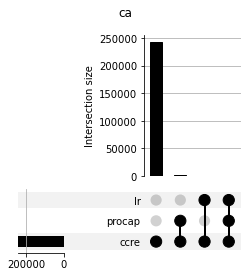

data/human/ccre/intersect/ca_ctcf.bed


<Figure size 432x288 with 0 Axes>

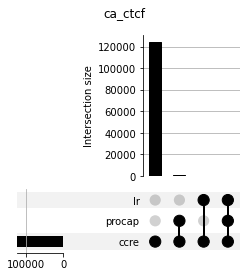

data/human/ccre/intersect/ca_h3k4me3.bed


<Figure size 432x288 with 0 Axes>

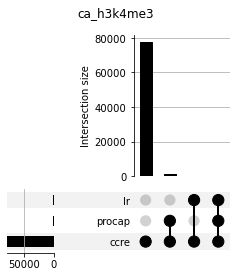

data/human/ccre/intersect/ca_tf.bed


<Figure size 432x288 with 0 Axes>

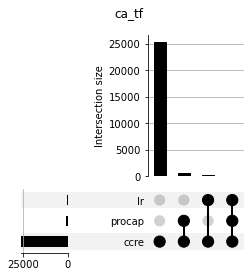

data/human/ccre/intersect/dels.bed


<Figure size 432x288 with 0 Axes>

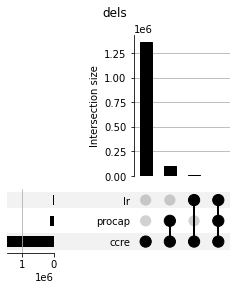

data/human/ccre/intersect/pels.bed


<Figure size 432x288 with 0 Axes>

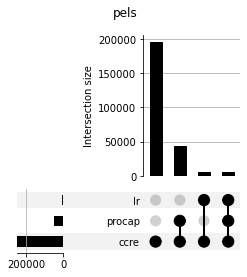

data/human/ccre/intersect/pls.bed


<Figure size 432x288 with 0 Axes>

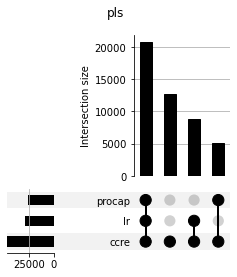

data/human/ccre/intersect/tf.bed


<Figure size 432x288 with 0 Axes>

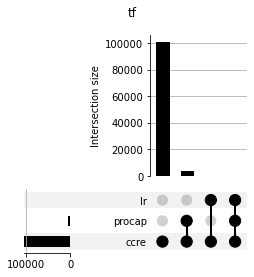

<Figure size 432x288 with 0 Axes>

In [24]:
# plot some upset plots
for f in ccre_bed_files:
    print(f)
    df = pd.read_csv(f, sep='\t')
    assay_list = [cats.split(',') for cats in df.assay.tolist()]
    temp = upsetplot.from_memberships(assay_list)
    ax_dict = upsetplot.UpSet(temp, subset_size='count', sort_by='cardinality').plot()
    plt.suptitle(f.split('/')[-1].split('.bed')[0])
    plt.show()
    plt.clf()


In [25]:
## generalized version that can intersect any way

In [30]:
species = 'human'
pc_bed_files = expand(config['procap']['bed_format'],
                     pc_biosamp='k562',
                     pc_rep='1',
                     pc_output=['bidirectional_peaks', 'unidirectional_peaks'],
                     species=species)
lr_bed_files = expand(config['lr']['bed_format'],
                     lr_biosamp='k562',
                     lr_rep='1',
                     species=species)
ccre_bed_file = expand(config['ccre']['bed_format'],
                       species='human',
                       ccre_type='pls')[0]

In [ ]:
def bed_intersect(left_file,
                  right_files,
                  ofile):
    left = pr.read_csv(left_file, sep='\t')
    left['Name'] = left.Chromosome.astype(str)+'_'+\
                   left.Start.astype(str)+'_'+\
                   left.End.astype(str)

    # get concatenation of all bed files
    right = pd.DataFrame()
    for f in bed_files:
        temp = pd.read_csv(f, sep='\t')
        right = pd.concat([df, temp], axis=0)

    # merge
    left = pr.PyRanges(left)
    right = pr.PyRanges(right)

    left = left.join(df,
         how='left',
         slack=0,
         suffix='_other').df

    # get support for each ccre by each assay
    temp = ccre[['Name', 'assay']].drop_duplicates()
    temp = temp.sort_values(by='assay', ascending=True)
    temp = temp.loc[temp.assay!='-1']
    assay_list = [temp.assay.unique()]+[np.nan]
    temp = temp.groupby('Name').agg({'assay':','.join}, axis=0).reset_index()
    temp['assay'] = temp['assay']+',ccre'

    # now make table w/ support for each ccre
    ccre = pr.read_bed(ccre_file).df
    ccre = ccre.merge(temp, how='left', on='Name')
    ccre.loc[ccre.assay.isnull(), 'assay'] = 'ccre'

    # and save
    ccre.to_csv(ofile, sep='\t', index=False)

In [3]:
species = 'human'
pc_bed_files = expand(config['procap']['bed_format'],
                     pc_biosamp='k562',
                     pc_rep='1',
                     pc_output=['bidirectional_peaks', 'unidirectional_peaks'],
                     species=species)
lr_bed_files = expand(config['lr']['bed_format'],
                     lr_biosamp='k562',
                     lr_rep='1',
                     species=species)

ccre_bed_file = expand(config['ccre']['bed'],
                       species='human',
                       ccre_type='pls')[0]

In [4]:
def intersect_ccre(ccre_file,
                   bed_files,
                   ofile):
    ccre = pr.read_bed(ccre_file)
    
    # get concatenation of all bed files
    df = pd.DataFrame()
    for f in bed_files:
        temp = pd.read_csv(f, sep='\t')
        df = pd.concat([df, temp], axis=0)
        
    # merge w/ ccre data
    df = pr.PyRanges(df)

    ccre = ccre.join(df,
         how='left',
         slack=0,
         suffix='_other').df
    
    
    # get support for each ccre by each assay
    temp = ccre[['Name', 'assay']].drop_duplicates()
    temp = temp.sort_values(by='assay', ascending=True)
    temp = temp.loc[temp.assay!='-1']
    assay_list = [temp.assay.unique()]+[np.nan]
    temp = temp.groupby('Name').agg({'assay':','.join}, axis=0).reset_index()
    temp['assay'] = temp['assay']+',ccre'
    
    # now make table w/ support for each ccre
    ccre = pr.read_bed(ccre_file).df   
    ccre = ccre.merge(temp, how='left', on='Name')    
    ccre.loc[ccre.assay.isnull(), 'assay'] = 'ccre'    
    
    # and save
    ccre.to_csv(ofile, sep='\t', index=False)

In [5]:
intersect_ccre(ccre_bed_file,
                   lr_bed_files+pc_bed_files,
                   'test.tsv')

In [149]:
ccre = pr.read_bed(ccre_bed_file)

In [150]:
df = pd.DataFrame()
for f in lr_bed_files+pc_bed_files:
    temp = pd.read_csv(f, sep='\t')
    df = pd.concat([df, temp], axis=0)

In [151]:
# merge w/ ccre data
df = pr.PyRanges(df)

ccre = ccre.join(df,
         how='left',
         slack=0,
         suffix='_other').df

In [152]:
# get support for each ccre by each assay
temp = ccre[['Name', 'assay']].drop_duplicates()
temp = temp.sort_values(by='assay', ascending=True)
temp = temp.loc[temp.assay!='-1']
assay_list = [temp.assay.unique()]+[np.nan]
temp = temp.groupby('Name').agg({'assay':','.join}, axis=0).reset_index()
temp['assay'] = temp['assay']+',ccre'

In [153]:
ccre = pr.read_bed(ccre_bed_file).df

In [154]:
temp.head()

,Name,assay
0,EH38D1301087,"lr,procap,ccre"
1,EH38D2115579,"lr,procap,ccre"
2,EH38D2116609,"lr,procap,ccre"
3,EH38D2116728,"lr,procap,ccre"
4,EH38D2119156,"lr,procap,ccre"


In [155]:
ccre.head()

,Chromosome,Start,End,Name,Score,Strand
0,chr1,778570,778919,EH38D4327580,EH38E2776539,PLS
1,chr1,779023,779182,EH38D6144726,EH38E3951314,PLS
2,chr1,817080,817403,EH38D2115333,EH38E1310166,PLS
3,chr1,826734,826887,EH38D4327607,EH38E2776553,PLS
4,chr1,826894,827162,EH38D4327608,EH38E2776554,PLS


In [156]:
ccre = ccre.merge(temp, how='left', on='Name')

In [158]:
ccre.loc[ccre.assay.isnull(), 'assay'] = 'ccre'

In [163]:
assay_list = [cats.split(',') for cats in ccre.assay.tolist()]
df = upsetplot.from_memberships(assay_list)
ax_dict = upsetplot.UpSet(df, subset_size='count').plot()


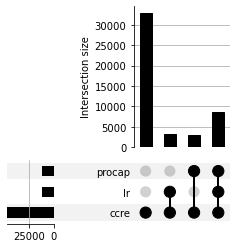

In [164]:
ax_dict = upsetplot.UpSet(df, subset_size='count').plot()


In [ ]:
## older

In [42]:
species = 'human'
pc_bed_file = expand(config['procap']['bed_format'],
                     pc_biosamp='k562',
                     pc_rep='1',
                     pc_output='bidirectional_peaks',
                     species=species)[0]
pc_bed_file_2 = expand(config['procap']['bed_format'],
                     pc_biosamp='k562',
                     pc_rep='1',
                     pc_output='unidirectional_peaks',
                     species=species)[0]
lr_bed_file = expand(config['lr']['bed_format'],
                     lr_biosamp='k562',
                     lr_rep='1',
                     species=species)[0]

ccre_bed_file = expand(config['ccre']['bed'],
                       species='human',
                       ccre_type='pls')[0]

In [43]:
df = pr.read_bed(pc_bed_file)
df.head()


,Chromosome,Start,End,Name,Score,Strand,ThickStart
0,chr1,629340,629643,procap,k562,1,bidirectional_peaks
1,chr1,629899,629978,procap,k562,1,bidirectional_peaks
2,chr1,630573,630702,procap,k562,1,bidirectional_peaks
3,chr1,634027,634244,procap,k562,1,bidirectional_peaks
4,chr1,778569,778809,procap,k562,1,bidirectional_peaks
5,chr1,827478,827702,procap,k562,1,bidirectional_peaks
6,chr1,904389,904462,procap,k562,1,bidirectional_peaks
7,chr1,904679,904849,procap,k562,1,bidirectional_peaks


In [44]:
df = pr.read_bed(pc_bed_file_2)
df.head()


,Chromosome,Start,End,Name,Score,Strand,ThickStart
0,chr1,115726,115733,procap,k562,1,unidirectional_peaks
1,chr1,633845,633848,procap,k562,1,unidirectional_peaks
2,chr1,633884,634026,procap,k562,1,unidirectional_peaks
3,chr1,943372,943376,procap,k562,1,unidirectional_peaks
4,chr1,944529,944539,procap,k562,1,unidirectional_peaks
5,chr1,1017579,1017584,procap,k562,1,unidirectional_peaks
6,chr1,1157495,1157520,procap,k562,1,unidirectional_peaks
7,chr1,1157655,1157728,procap,k562,1,unidirectional_peaks


In [ ]:
for f in 

In [12]:
# get lists to expand w/ 
pc_biosamps = ['k562']
pc_reps = ['1']
pc_outputs = ['bidirectional_peaks']
pc_species = ['human']

lr_biosamps = ['k562']
lr_reps = ['1']
lr_species=['human']

In [14]:
species = 'human'
pc_bed_files = expand(config['procap']['bed'],
                     pc_biosamp=pc_biosamps,
                     pc_rep=pc_reps,
                     pc_output=pc_outputs,
                     species=pc_species)
lr_bed_files = expand(config['lr']['bed'],
                     lr_biosamp=lr_biosamps,
                     lr_rep=lr_reps,
                     species=lr_species)

ccre_bed_file = expand(config['ccre']['bed'],
                       species='human',
                       ccre_type='pls')[0]

In [21]:
# lr_bed = pr.read_bed(lr_bed_file)
# pc_bed = pr.read_bed(pc_bed_file)

# loop through each procap bed file and cat them together with the relevant info
df = pd.DataFrame()
for f, b, r, o in zip(pc_bed_files,
                      pc_biosamps,
                      pc_reps,
                      pc_outputs):
    temp = pr.read_bed(f, as_df=True)
    temp['assay'] = 'procap'
    temp['biosample'] = b
    temp['rep'] = r
    temp['output'] = o
    df = pd.concat([df, temp], axis=0)
    
# do the same with the lr bed files
for f, b, r in zip(lr_bed_files,
                                 lr_biosamps,
                                 lr_reps):
    temp = pr.read_bed(f, as_df=True)
    temp['assay'] = 'lr'
    temp['biosample'] = b
    temp['rep'] = r
    df = pd.concat([df, temp], axis=0)

In [20]:
df

,Chromosome,Start,End,Name,Score,Strand,assay,biosample,rep,output
0,chr1,629340,629643,Relaxed,629639,629341,procap,k562,1,bidirectional_peaks
1,chr1,629899,629978,Stringent(qval),629909,629955,procap,k562,1,bidirectional_peaks
2,chr1,630573,630702,Relaxed,630681,630574,procap,k562,1,bidirectional_peaks
3,chr1,634027,634244,Relaxed,634243,634032,procap,k562,1,bidirectional_peaks
4,chr1,778569,778809,Stringent(qval),778808,778612,procap,k562,1,bidirectional_peaks
...,...,...,...,...,...,...,...,...,...,...
18352,chrX,155216874,155216925,Relaxed,155216924,155216883,procap,k562,1,bidirectional_peaks
18353,chrX,155334610,155334745,Relaxed,155334744,155334613,procap,k562,1,bidirectional_peaks
18354,chrX,155612927,155613058,Stringent(qval),155613031,155612933,procap,k562,1,bidirectional_peaks
18355,chrX,155881181,155881419,Stringent(pval),155881357,155881182,procap,k562,1,bidirectional_peaks


In [9]:
ccre_bed = pr.read_bed(ccre_bed_file)